# IBM Watson OpenScale Explainability on Sentiment Prediction by Watson NLP

## Usecase - Hotel Guest Reviews

This notebook demonstrates how to run OpenScale explainability and quality monitoring on the Watson NLP sentiment prediction outcomes. This feature is performed on the hotel gues reviews.

The data is available at https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

    syntax_model = watson_nlp.load('syntax_izumo_en_stock')
    sentiment_model = watson_nlp.load('sentiment_sentence-bert_multi_stock')    

- **Sentiment classification** - with the _Sentiment classification model_ for Engine (`sentiment_sentence-bert_multi_stock`), with the syntax parsing on the sentences (reviews) done using the _Syntax model_ (`syntax_izumo_en_stock`).
- **Predict Document Sentiment** - The Watson NLP sentiment analysis provides sentiments on each part of the sentence. For example for the guest provided review of `The hotel room is good. Food is bad. View is okay.`, the sentiments are Positive for `The hotel room is good` and `Negative` for `Food is bad`, and `Neutral` for `View is okay`. This becomes multi-predictions problem, hence we would find out Document Sentiment, aka Overall Prediction which is what would be used as the prediction for monitoring purposes.
- **Python Function Deployment** - The document prediction code is wrapped to a python function and thereby deployed to IBM Watson Machine Learning.
- **OpenScale Configuration** - Configure the Python Function as a Custom ML Provider - so that we do not let OpenScale do Shadow deployment for the python function where the same Watson NLP package is deployed again, so as to save resources.
- **OpenScale Explainability Evaluation** - Configure LIME based explanation, and run explain on a sample transaction which is logged as part of the Subscription creation.
- **OpenScale Quality Monitoring** - Load feedback data and run Quality Monitoring.

<a id="beforeYouStart"></a>
## Before you start

Run the steps mentioned in https://www.ibm.com/docs/en/cloud-paks/cp-data/4.6.x?topic=ws-post-installation-setup#nlp in your CP4D Cluster.

Specifically the step mentioned in `Installing pre-trained NLP models for Python-based notebook runtimes`

```
oc patch -n ${PROJECT_CPD_INSTANCE} NotebookRuntime ibm-cpd-ws-runtime-222-py --type=merge --patch '{"spec":{"install_nlp_models":true}}'
```


You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP Environment_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [1]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [2]:
import watson_nlp

In [3]:
watson_nlp.lib_config.library_version

'3.6.0'

#### Make sure the NLP Models are listed

In [4]:
!ls /opt/ibm/nlpmodels

categories_esa_en_stock
embedding_glove_ar_stock
embedding_glove_de_stock
embedding_glove_en_stock
embedding_glove_es_stock
embedding_glove_fr_stock
embedding_glove_it_stock
embedding_glove_ja_stock
embedding_glove_ko_stock
embedding_glove_nl_stock
embedding_glove_pt_stock
embedding_glove_zh-cn_stock
embedding_use_en_stock
embedding_use_multi_large
embedding_use_multi_small
ensemble_classification-workflow_en_emotion-stock
ensemble_classification-workflow_en_tone-stock
ensemble_classification-workflow_fr_emotion-stock
ensemble_classification-workflow_fr_tone-stock
entity-mentions_bert_multi_stock
entity-mentions_rbr_ar_stock
entity-mentions_rbr_cs_stock
entity-mentions_rbr_da_stock
entity-mentions_rbr_de_stock
entity-mentions_rbr_en_stock
entity-mentions_rbr_es_stock
entity-mentions_rbr_fi_stock
entity-mentions_rbr_fr_stock
entity-mentions_rbr_he_stock
entity-mentions_rbr_hi_stock
entity-mentions_rbr_it_stock
entity-mentions_rbr_ja_stock
entity-mentions_rbr_ko_stock
entity-mentions_rbr

# Python Function that wraps the Sentiment Prediction

In [ ]:
def detect_sentiment():
    import watson_nlp
    import watson_nlp.data_model as dm
    from watson_nlp.toolkit import bert_utils, fileio
    from watson_nlp.toolkit import sentiment_analysis_utils as utils

    syntax_model = watson_nlp.load('syntax_izumo_en_stock')
    sentiment_model = watson_nlp.load('sentiment_sentence-bert_multi_stock')    

    def construct_predictions_response(document_sentiment):
        label = document_sentiment['label']
        positive_cumulative = 0
        neutral_cumulative = 0
        negative_cumulative = 0
        sentiment_mentions = document_sentiment['sentiment_mentions']
        for sentiment_mention in sentiment_mentions:
            sentimentprob = sentiment_mention['sentimentprob']
            positive_cumulative = positive_cumulative + sentimentprob['positive']
            neutral_cumulative = neutral_cumulative + sentimentprob['neutral']
            negative_cumulative = negative_cumulative + sentimentprob['negative']
        positive_prob = positive_cumulative / len(sentiment_mentions)
        neutral_prob = neutral_cumulative / len(sentiment_mentions)
        negative_prob = negative_cumulative / len(sentiment_mentions)

        sentimentprob = [positive_prob, neutral_prob, negative_prob]
        predictions_response = [label, sentimentprob]
        return predictions_response    

    def sentiment_prediction(review_text):
        syntax_result = syntax_model.run(review_text, parsers=('token', 'lemma', 'part_of_speech'))
        sentence_sentiments = sentiment_model.run_batch(syntax_result.get_sentence_texts(), syntax_result.sentences)
        document_sentiment = utils.predict_document_sentiment(sentence_sentiments, 
                                                        sentiment_model.class_idxs).to_dict()
        return document_sentiment
    
    def score(input):
        prediction_values = []
        values = input["input_data"][0]["values"]
        for value in values:
            review_text = value[0]
            document_sentiment = sentiment_prediction(review_text)
            predictions_response = construct_predictions_response(document_sentiment)
            prediction_values.append(predictions_response)

        scoring_response = {}
        fields = ["prediction", "probability"]        
        scoring_response['predictions'] = [
            {
                "fields" : fields,
                "values" : prediction_values
            }
        ]        
        return scoring_response    
    return score

### Local testing of the python function

In [9]:
scoring_payload = {
   'input_data': [{  
        'fields': ["Text"],
        'values': [
            ["The room is good. The view from room is excellent. Food is average. In-room dining is on time."],                        
            ["The room is nice, but the price is too expensive. The window frame is made of wood."],
            ["The room is okay."],            
            ["The check-in process is smooth."],
            ["The check-in was horrible."],
            ["The room service is bad."]
        ]
   }]
}

In [10]:
func_result = detect_sentiment()(scoring_payload)
print(func_result)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['SENT_POSITIVE', [0.5498881125822663, 0.28326629381626844, 0.16684558987617493]], ['SENT_NEGATIVE', [0.1923516783863306, 0.32753497175872326, 0.48011339269578457]], ['SENT_NEUTRAL', [0.248098224401474, 0.3874984383583069, 0.3644033670425415]], ['SENT_POSITIVE', [0.9146450757980347, 0.08112175017595291, 0.004233187530189753]], ['SENT_NEGATIVE', [0.002526152180507779, 0.004029619973152876, 0.9934442043304443]], ['SENT_NEGATIVE', [0.0015284158289432526, 0.04420212656259537, 0.9542693495750427]]]}]}


In [22]:
scoring_payload = {
   'input_data': [{  
        'fields': ["Text"],
        'values': [
            ["Hark, fair Grand Hotel! A wondrous abode, Whose staff so kind did bear a heavy load. Our spacious chamber, with views so divine, Did make us feel as if in Heaven's shrine. Facilities great, with food to delight, Highly recommended, though bath was slight."]
        ]
   }]
}

In [23]:
func_result = detect_sentiment()(scoring_payload)
print(func_result)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['SENT_POSITIVE', [0.5409789299592376, 0.21880972548387945, 0.24021127857849933]]]}]}


# Deploying the Python Function to IBM Watson Machine Learning

In [11]:
#masked
WOS_CREDENTIALS = {
    "url": "https://cpd-namespace1.apps.xxxxxxx.cp.fyre.ibm.com",
    "username": "admin",
    "password": "xxxxxxx"
}

WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS["instance_id"] = "wml_local"
WML_CREDENTIALS["version"] = "4.6" #If your env is CP4D 4.x.x then specify "4.x.x" instead of "4.6"

USER_API_KEY = 'xxxxxxxxx'

# The space where the WML model is deployed. Please note the model deployment is not actually used at runtime by OpenScale, but used only to generate the OpenScale monitor artifacts.
space_uid = '19fcec1c-62b9-41d1-a449-xxxxx'

# Using the default OpenScale instance. Change the instance id, as needed.
SERVICE_INSTANCE_ID="00000000-0000-0000-0000-000000000000"

In [12]:
from ibm_watson_machine_learning import APIClient
wml_client = APIClient(WML_CREDENTIALS)

In [13]:
wml_client.set.default_space(space_uid)

'SUCCESS'

In [14]:
PYTHON_FUNCTION_NAME = 'sentiment_function'
DEPLOYMENT_NAME = "nlp-sentiment-deploy"

#### Python Function cleanup

In [15]:
deployments_list = wml_client.deployments.get_details()
for deployment in deployments_list["resources"]:
    model_id = deployment["entity"]["asset"]["id"]
    deployment_id = deployment["metadata"]["id"]
    if deployment["metadata"]["name"] == DEPLOYMENT_NAME:
        print("Deleting deployment id", deployment_id)
        wml_client.deployments.delete(deployment_id)
        print("Deleting model id", model_id)
        wml_client.repository.delete(model_id)

wml_client.repository.list_functions()

Deleting deployment id 79042297-dc3a-4133-969a-0937b9bcc335
Deleting model id 30f8166c-f0df-412b-aac9-23d8b71932bc
----  ----  -------  ----  ----------  ----------------
GUID  NAME  CREATED  TYPE  SPEC_STATE  SPEC_REPLACEMENT
----  ----  -------  ----  ----------  ----------------


## Store the python function

In [16]:
pyfunc_swspec_id = wml_client.software_specifications.get_uid_by_name("runtime-22.2-py3.10")

meta_data = {
    wml_client.repository.FunctionMetaNames.NAME: PYTHON_FUNCTION_NAME,
    wml_client.repository.FunctionMetaNames.DESCRIPTION: PYTHON_FUNCTION_NAME,
    wml_client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: pyfunc_swspec_id
}


sentiment_function_details = wml_client.repository.store_function(meta_props=meta_data, function=detect_sentiment)

## Deploy the python function

In [17]:
sentiment_function_uid = wml_client.repository.get_function_uid(sentiment_function_details)

meta_props = {
   wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
   wml_client.deployments.ConfigurationMetaNames.DESCRIPTION: DEPLOYMENT_NAME,
   wml_client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: { 'name': 'M'},  
   wml_client.deployments.ConfigurationMetaNames.ONLINE: {   }
}

sentiment_deployment_details = wml_client.deployments.create(sentiment_function_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'c277d2f8-287b-4af5-a197-c03efe49f133' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
..........
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='2e7f832c-2774-4e5a-8c5d-9f1b81993df8'
------------------------------------------------------------------------------------------------




In [18]:
sentiment_deployment_id = wml_client.deployments.get_uid(sentiment_deployment_details)

In [19]:
function_details = wml_client.repository.get_details(sentiment_function_uid)
from pprint import pprint
pprint(function_details)

{'entity': {'software_spec': {'id': 'b56101f1-309d-549b-a849-eaa63f77b2fb',
                              'name': 'runtime-22.2-py3.10'},
            'type': 'python'},
 'metadata': {'created_at': '2023-04-29T06:49:53.037Z',
              'description': 'sentiment_function',
              'id': 'c277d2f8-287b-4af5-a197-c03efe49f133',
              'modified_at': '2023-04-29T06:49:53.298Z',
              'name': 'sentiment_function',
              'owner': '1000330999',
              'space_id': '19fcec1c-62b9-41d1-a449-dfee0a531a67'},
 'system': {'warnings': []}}


## Get the scoring endpoint for the deployed python function

In [20]:
scoring_url = wml_client.deployments.get_scoring_href(sentiment_deployment_details)

## Scoring against the deployed function

In [24]:
predictions = wml_client.deployments.score(sentiment_deployment_id, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['SENT_POSITIVE',
     [0.5409789439290762, 0.21880972769577056, 0.24021128262393177]]]}]}

# IBM Watson OpenScale

In [25]:
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator
from ibm_watson_openscale import APIClient

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *
from ibm_watson_openscale.base_classes.watson_open_scale_v2 import *

In [26]:
authenticator = CloudPakForDataAuthenticator(
        url=WML_CREDENTIALS['url'],
        username=WML_CREDENTIALS['username'],
        password=WML_CREDENTIALS['password'],
        disable_ssl_verification=True
    )

wos_client = APIClient(service_url=WML_CREDENTIALS['url'],authenticator=authenticator, service_instance_id=SERVICE_INSTANCE_ID)
wos_client.version

'3.0.28'

In [27]:
SERVICE_PROVIDER_NAME = "Text Model Prediction Provider - Prod"
SERVICE_PROVIDER_DESCRIPTION = "Text Model Prediction Provider - Prod"

In [28]:
DB_CREDENTIALS = None
KEEP_MY_INTERNAL_POSTGRES = True

In [29]:
data_marts = wos_client.data_marts.list().result.data_marts
data_mart_id=data_marts[0].metadata.id
print('Using existing datamart {}'.format(data_mart_id))

Using existing datamart 00000000-0000-0000-0000-000000000000


## Service Provider Cleanup

In [30]:
service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for WML instance: {}".format(service_provider_id))

Deleted existing service_provider for WML instance: 99b15e3d-47d7-4eae-93e7-a5e02eaa3ef8


## Service Provider Creation for the Python Function Deployment URL as the Custom ML Provider

In [31]:
MLCredentials = {
        "auth_type": "api_key",
        "apikey": USER_API_KEY,
        "auth_url": WML_CREDENTIALS['url'],
        "auth_provider": "cpd",
        "username": WML_CREDENTIALS['username']
    }

In [32]:
request_headers = {"Content-Type": "application/json", "Custom_header_X": "Custom_header_X_value_Y"}

added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.CUSTOM_MACHINE_LEARNING,
        request_headers=request_headers,
        operational_space_id = "production",
        credentials=MLCredentials,
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id




 Waiting for end of adding service provider 10cb0a92-1655-41f5-ad12-4c6fba8bc273 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------




In [34]:
print('Data Mart ID : ' + data_mart_id)
print('Service Provider ID : ' + service_provider_id)

Data Mart ID : 00000000-0000-0000-0000-000000000000
Service Provider ID : 10cb0a92-1655-41f5-ad12-4c6fba8bc273


## Subscription Cleanup

In [35]:
subscriptions = wos_client.subscriptions.list().result.subscriptions
for subscription in subscriptions:
    sub_model_id = subscription.entity.asset.asset_id
    if sub_model_id == sentiment_function_uid:
        wos_client.subscriptions.delete(subscription.metadata.id)
        print('Deleted existing subscription for model', sub_model_id)

## Subscription details

In [36]:
import uuid
asset_id = str(uuid.uuid4())
asset_name = '[asset] ' + DEPLOYMENT_NAME
url = ''

asset_deployment_id = str(uuid.uuid4())
asset_deployment_name = asset_name
asset_deployment_scoring_url = scoring_url

scoring_endpoint_url = scoring_url
scoring_request_headers = {
        "Content-Type": "application/json"
    }

## Subscription creation as Multi Classification problem, and for Unstructured text data type

In [37]:
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=Asset(
            asset_id=asset_id,
            name=asset_name,
            url=url,
            asset_type=AssetTypes.MODEL,
            input_data_type=InputDataType.UNSTRUCTURED_TEXT,
            problem_type=ProblemType.MULTICLASS_CLASSIFICATION
        ),
        deployment=AssetDeploymentRequest(
            deployment_id=asset_deployment_id,
            name=asset_deployment_name,
            deployment_type= DeploymentTypes.ONLINE,
            scoring_endpoint=ScoringEndpointRequest(
                url=scoring_endpoint_url,
                request_headers=scoring_request_headers
            )
        ),
        asset_properties=AssetPropertiesRequest(
            label_column='label',
            probability_fields=["probability"],
            prediction_field="prediction",
            feature_fields = ["Text"],
            categorical_fields = ["Text"]
        )
    ).result
subscription_id = subscription_details.metadata.id

In [38]:
print('Subscription ID: ' + subscription_id)

Subscription ID: 3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2


### Get the Payload logging data set id

In [39]:
import time

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  20d09698-674d-47ac-9f12-e07aefef792c


In [40]:
wos_client.subscriptions.show()

3a2aed9f-85fe-432c-af28-77f8e627647a,[asset] nlp-sentiment-deploy,00000000-0000-0000-0000-000000000000,d99d3246-b706-4359-aba8-67d483ebd5ca,[asset] nlp-sentiment-deploy,10cb0a92-1655-41f5-ad12-4c6fba8bc273,active,2023-04-29 06:52:20.375000+00:00,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
3a5ecd87-171e-4d10-9f29-d7453e34b47f,Text Binary Classifier,00000000-0000-0000-0000-000000000000,c3542da5-90a7-4a00-80bc-ef7242544fbf,Text Binary Classifier deployment,20158219-ac50-4603-971d-a35f5bcc4e40,active,2023-04-28 08:19:17.995000+00:00,25bf647b-26e0-4a93-b7f4-2a960d28113c
954cfe83-0323-4d72-ab84-b064d38eac5b,[asset] Batch Demo,00000000-0000-0000-0000-000000000000,5a8a4517-e430-4745-ae7b-0723262087da,Batch Demo,fc019f82-69b4-4181-9e41-7a508910a5c2,active,2023-04-18 14:51:27.603000+00:00,dd2d1adb-5785-4431-84b4-9804c6593953
3925c2f4-77fd-445d-b919-40931389b128,Dog-Cat binary- Neelima,00000000-0000-0000-0000-000000000000,50cbaebb-d64d-4ade-b7e7-2ab6843396ef,Dog-Cat binary- Neelima deployment,dbca1f59-8504-4eaa-8570-f03a51c91ac8,active,2023-04-27 05:57:34.271000+00:00,068660a6-7a41-40b5-bf1f-99fdbf3fadd2
f7595278-e09e-4b9f-bd73-cbf999ea0438,Test Harry Native_XGBoost binary_4677422a-2a56-43f8-95c1-684a5b1a97b2,00000000-0000-0000-0000-000000000000,be8627c0-b485-4ece-b730-71f21985c28f,Test Harry Native_XGBoost binary_4677422a-2a56-43f8-95c1-684a5b1a97b2 Deployment,19defa93-99b0-40c0-8f1b-c96df84efb65,active,2023-04-25 16:47:10.782000+00:00,02618bba-75fb-419d-9012-34cb9e546637
3ed78fc6-d45b-417a-86d3-454e1cc687a6,Test Harry Native_XGBoost binary_ba458696-c42a-4de6-b419-59c5bdf8ef03,00000000-0000-0000-0000-000000000000,f2fa0440-d8c0-4fd8-8d42-299f1169c085,Test Harry Native_XGBoost binary_ba458696-c42a-4de6-b419-59c5bdf8ef03 Deployment,19defa93-99b0-40c0-8f1b-c96df84efb65,active,2023-04-25 14:23:24.453000+00:00,28fa8ac7-3d94-448d-9e4b-02e1e897496a
ee9ae784-a501-4467-964b-5c6b3456a430,MNIST Model,00000000-0000-0000-0000-000000000000,74599062-507b-442a-abf3-6a98cf7d59f2,MNIST Model deployment,391a18a0-c591-4e17-b2be-a39788231faa,active,2023-04-25 14:19:39.456000+00:00,03782069-af31-4143-9bc1-0ac98aeb53b2
7ffaeef1-b4d3-4ea8-b664-f2b1fd878187,AIOS Keras Multiclass StackOverflow V4,00000000-0000-0000-0000-000000000000,aa28bdf5-5a0c-436e-89dc-a8620ab1c561,AIOS Keras Multiclass StackOverflow V4 Deployment 01,19defa93-99b0-40c0-8f1b-c96df84efb65,active,2023-04-21 07:06:54.036000+00:00,d94e8747-e231-4cf3-8fd3-ce514340d84a
269e9c00-c01c-488c-ac3e-92c728bd12f0,Test Harry Dog-Cat binary Test 02,00000000-0000-0000-0000-000000000000,d658e8cb-1727-4cd9-87cf-a74943f919b4,Test Harry Dog-Cat binary Test 02 deployment,19defa93-99b0-40c0-8f1b-c96df84efb65,active,2023-04-20 17:44:40.010000+00:00,7afe08c4-b160-4016-989f-46976caca807
cda2135d-0baf-41f6-b25f-cbdd3adf557a,Test Harry Dog-Cat binary Test 01,00000000-0000-0000-0000-000000000000,165df727-d3a2-419f-bbea-ed10929e92a0,Test Harry Dog-Cat binary Test 01 deployment,19defa93-99b0-40c0-8f1b-c96df84efb65,active,2023-04-20 17:13:32.808000+00:00,d530b735-c659-46e9-9145-fb97b05d4c14


Note: First 10 records were displayed.


### Perform Payload Logging using the scored data

In [42]:
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
def payload_logging(scoring_payload, scoring_response):
    scoring_id = str(uuid.uuid4())
    records_list=[]
    
    #manual PL logging for custom ml provider
    pl_record = PayloadRecord(scoring_id=scoring_id, request=scoring_payload, response=scoring_response, response_time=int(460))
    records_list.append(pl_record)
    wos_client.data_sets.store_records(data_set_id = payload_data_set_id, request_body=records_list)
    
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))
    return scoring_id

In [43]:
payload_logging(scoring_payload, predictions)

Number of records in the payload logging table: 1


'efc2ffea-2efe-4ad5-ba37-af6819069853'

### Make sure records reached the payload logging table

In [44]:
time.sleep(5)
wos_client.data_sets.get_records_count(payload_data_set_id)

1

# IBM Watson OpenScale - Explainability

In [45]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True,
    "perturbations_count": 100
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result

explainability_monitor_id = explainability_details.metadata.id




 Waiting for end of monitor instance creation 439f9f60-ba09-4456-a1be-1b63017037d9 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




## Sample records for which explainability needs to run

In [46]:
payload_data = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id,output_type='pandas').result
explanation_types = ["lime"]

scoring_ids = payload_data.head(1)['scoring_id'].tolist()
print(scoring_ids)

['efc2ffea-2efe-4ad5-ba37-af6819069853-1']


## Run explainability

In [47]:
import sys,os,os.path
import json
import requests
import base64
from requests.auth import HTTPBasicAuth
import time

In [48]:
headers = {}
headers["Content-Type"] = "application/json"
headers["Authorization"] = "Bearer {}".format(os.environ['USER_ACCESS_TOKEN'])

### Explain payload

In [49]:
explanations_tasks_payload = {
  "scoring_ids": scoring_ids,
  "subscription_id": subscription_id,
  "explanation_types": ["lime"],
  "parameters": {
       "lime": {
          "perturbations_count": 100
       }
   }
}

### Submit the explain task

In [50]:
explanations_tasks_url =  WML_CREDENTIALS['url'] + "/openscale/{0}/v2/explanation_tasks".format(data_mart_id)
response = requests.post(explanations_tasks_url, json=explanations_tasks_payload, headers=headers, verify=False)
json_data = response.json()
print(json_data)

{'metadata': {'created_at': '2023-04-29T06:53:56.406563Z', 'created_by': '1000330999', 'explanation_task_ids': ['4684ef02-4950-4d40-aee1-64a2cc2fa964']}}


In [51]:
explanation_task_ids = json_data['metadata']['explanation_task_ids']
explanation_task_ids

['4684ef02-4950-4d40-aee1-64a2cc2fa964']

### Check for the status of the explain run.

In [52]:
def finish_explanation_tasks(sample_size = 1):
    finished_explanations = []
    finished_explanation_task_ids = []
    
    # Check for the explanation task status for finished status. 
    # If it is in-progress state, then sleep for some time and check again. 
    # Perform the same for couple of times, so that all tasks get into finished state.
    for i in range(0, 5):
        # for each explanation
        print('iteration ' + str(i))
        
        #check status for all explanation tasks
        for explanation_task_id in explanation_task_ids:
            if explanation_task_id not in finished_explanation_task_ids:
                result = wos_client.monitor_instances.get_explanation_tasks(explanation_task_id=explanation_task_id, subscription_id=subscription_id ).result
                print(explanation_task_id + ' : ' + result.entity.status.state)
                if (result.entity.status.state == 'finished' or result.entity.status.state == 'error') and explanation_task_id not in finished_explanation_task_ids:
                    finished_explanation_task_ids.append(explanation_task_id)
                    finished_explanations.append(result)


        # if there is altest one explanation task that is not yet completed, then sleep for sometime, 
        # and check for all those tasks, for which explanation is not yet completeed.
        
        if len(finished_explanation_task_ids) != sample_size:
            print('sleeping for some time..')
            time.sleep(10)
        else:
            break
                    
    return finished_explanations

In [53]:
finished_explanations = finish_explanation_tasks(1)

iteration 0
4684ef02-4950-4d40-aee1-64a2cc2fa964 : finished


### Print the explain result

In [55]:
for result in finished_explanations:
    print(result)

{
  "metadata": {
    "explanation_task_id": "4684ef02-4950-4d40-aee1-64a2cc2fa964",
    "created_by": "1000330999",
    "created_at": "2023-04-29T06:53:56.406563Z",
    "updated_at": "2023-04-29T06:54:23.273032Z"
  },
  "entity": {
    "status": {
      "state": "finished"
    },
    "asset": {
      "id": "3a2aed9f-85fe-432c-af28-77f8e627647a",
      "name": "[asset] nlp-sentiment-deploy",
      "input_data_type": "unstructured_text",
      "problem_type": "multiclass",
      "deployment": {
        "id": "d99d3246-b706-4359-aba8-67d483ebd5ca",
        "name": "[asset] nlp-sentiment-deploy"
      }
    },
    "input_features": [
      {
        "name": "Text",
        "value": "Hark, fair Grand Hotel! A wondrous abode, Whose staff so kind did bear a heavy load. Our spacious chamber, with views so divine, Did make us feel as if in Heaven's shrine. Facilities great, with food to delight, Highly recommended, though bath was slight."
      }
    ],
    "perturbed": false,
    "explanatio

# IBM Watson OpenScale - Quality Monitoring

## Quality monitor configuration

In [56]:
import time

#time.sleep(10)
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 100
}
thresholds = [
                {
                    "metric_id": "accuracy",
                    "type": "lower_limit",
                    "value": .90
                },
                {
                    "metric_id": "weighted_true_positive_rate",
                    "type": "lower_limit",
                    "value": .90
                },
                {
                    "metric_id": "weighted_precision",
                    "type": "lower_limit",
                    "value": .90
                },
                {
                    "metric_id": "log_loss",
                    "type": "upper_limit",
                    "value": .90
                },
                {
                    "metric_id": "weighted_recall",
                    "type": "lower_limit",
                    "value": .90
                },
                {
                    "metric_id": "weighted_f_measure",
                    "type": "lower_limit",
                    "value": .90
                }
,
                {
                    "metric_id": "weighted_false_positive_rate",
                    "type": "upper_limit",
                    "value": .20
                }    
    
            ]
quality_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters,
    thresholds=thresholds
).result




 Waiting for end of monitor instance creation e4323870-d293-45e5-9410-a3db24cbabb8 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [57]:
quality_monitor_instance_id = quality_monitor_details.metadata.id
quality_monitor_instance_id

'e4323870-d293-45e5-9410-a3db24cbabb8'

### Get the feedback data set id

In [58]:
feedback_dataset_id = None
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result
feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")

In [59]:
feedback_dataset_id

'a983b51d-2282-413f-9d2e-1a2d17148272'

## Load feedback data to feedback logging table

In [60]:
feed_data_load = pd.read_csv('https://raw.githubusercontent.com/ravichamarthy/watson-nlp/main/tripadvisor_hotel_reviews_feedback_data_100_records.csv')
feedback_data = json.loads(feed_data_load.to_json(orient='records'))

In [61]:
wos_client.data_sets.store_records(feedback_dataset_id, request_body=feedback_data, background_mode=False)




 Waiting for end of storing records with request id: 3d9f951c-8569-4661-a080-7cf58b982499 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------




In [62]:
wos_client.data_sets.show_records(data_set_id=feedback_dataset_id)

0252e6ff-adbe-466d-bb99-94e120cf572d,2023-04-29T12:59:18.570Z,SENT_NEGATIVE,None,"terrible hotel approximately 2 weeks ago april 25 2007 reservation hotel night 19 2007, wrote follow-up request reply advised reservation cancelled overbooking.i wote giving reservation number just wrote just saying sorry making no effort room nearby hotel, rhe emails brigeta operation manager, not written approximately 2 weeks stay positive left scrambe new hotel lobby inn queen anne.i practice unforgivable especially light having resevation number guarenteeing room 19 2007. point making advance reservations hotel suddenly cancel little advance notice sincerely greg scanlonsan francisco,"
39239395-2b89-4bd7-8026-5c3cd97b8993,2023-04-29T12:59:18.570Z,SENT_POSITIVE,None,"return going seattle booked hotel knowing budget hotel, check-in friends met friendly warm welcome, rooms read reviews simple charming, beds-ok bathroom-ok really big closet nice little kitchenette.the breakfast not described great experience needs little kitchenette, bring coffee lobby prepare bacon eggs bought supermarket located not 150 metres away.what stay great experience friendly staff especially dana conveniant compementary shuttle service low price great location, 10-15 minute walk city center 2 minutes key arena 20 minutes hooters restaurant 20 minutes pike market 8 minutes space needle.///anders friends,"
a8132ef0-3631-4ee8-918b-66471855f8ba,2023-04-29T12:59:18.570Z,SENT_POSITIVE,None,"great price okay experience stayed inn queen anne nights mid-january 2007. price good 79/night room fine, old shabby clean comfortable, having kitchenette microwave stove sink fridge great room surprisingly large walk-in closet, service friendly no warned desk staff leaves 11:00 pm, calls desk hour fielded staff hotel problem example needed request iron ironing board morning n't able guy hotel n't queen anne answer phone, inn queen anne no elevator n't problem big problem some.the downside noise, hotel no soundproofing rooms night bed 2:30 ask next-door neighbors kind party going hold, morning plumbing noise deafening morning awakened 6:00 pm showers rooms me.however location great hotel just north space needle smack middle seattle bohemian-hip neighborhood, excellent cd shop just corner restaurants safeway, deep sleeper n't need first-class accomodations hotel good bargain,"
fce6bc4c-4153-448c-80ad-ffe8aa36326e,2023-04-29T12:59:18.570Z,SENT_NEGATIVE,None,"old dumpy place problems head starts spinning thinking start, got like 10pm check-in told park street cuz no parking left lot, room tiny carpet dirty spots, room came kitchen nasty used, especially fridge time opened nasty odor rotten vegetables gushed fridge filled entire room, day night hear people talking walking stairwell right outside, noise streets right outside window substantial, just no sound insulation place, bathroom surprisingly clean room appeared well-kept, shower pressure horrible stay ran hot water twice, fact morning took cold shower basically start end, desk staff generally nice, guy completely uncaring unhelpful not sure problem, thing liked place ceiling fan walk-in closet, paid 100/night place suppose reasonable seattle center area, pay 40 night stay holiday inn express, basically ca n't recommend place,"
023a1f1a-36bf-4118-9e37-714e17aa3162,2023-04-29T12:59:18.569Z,SENT_POSITIVE,None,"not bad place stay short term n't expect, want roominess amenities not walk stairs not place you.if day just need place sleep shower fine place, rate good compared lodgings city.it old 1920 built twin apartment buildings retired priests nuns, building sisters priests.our room queen bed large walk-in closet kitchenette bath, clean adequate night stay.the staff friendly bellboy..adam nice helpful, stairway funny smell mildew like room no air conditioner no smell, temps hit 90 open windows ceiling fan bearable, hot temperature seattle rare.this street city center old 1962 worlds fair site space needle park amusement rides short walk away

In [63]:
time.sleep(5)
wos_client.data_sets.get_records_count(feedback_dataset_id)

100

## Run Quality Monitor

In [64]:
run_details = wos_client.monitor_instances.run(monitor_instance_id=quality_monitor_instance_id, background_mode=False).result




 Waiting for end of monitoring run 137442ce-7182-4006-b50d-438f07a8f87d 




running...
finished

---------------------------
 Successfully finished run 
---------------------------




## Fetch the Quality Metrics

In [65]:
time.sleep(5)
wos_client.monitor_instances.show_metrics(monitor_instance_id=quality_monitor_instance_id)

2023-04-29 12:59:34.718000+00:00,accuracy,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.7,0.9,None,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
2023-04-29 12:59:34.718000+00:00,weighted_true_positive_rate,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.7000000000000001,0.9,None,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
2023-04-29 12:59:34.718000+00:00,weighted_precision,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.8398847926267281,0.9,None,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
2023-04-29 12:59:34.718000+00:00,log_loss,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.824428631809492,None,0.9,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
2023-04-29 12:59:34.718000+00:00,weighted_recall,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.7000000000000001,0.9,None,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
2023-04-29 12:59:34.718000+00:00,weighted_f_measure,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.7583204134366925,0.9,None,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2
2023-04-29 12:59:34.718000+00:00,weighted_false_positive_rate,7f4a8dd9-0ffe-4df7-bfb8-41078feb22ac,0.20242876526458614,None,0.2,['model_type:original'],quality,e4323870-d293-45e5-9410-a3db24cbabb8,137442ce-7182-4006-b50d-438f07a8f87d,subscription,3ec76a28-de0b-4b64-bd87-e0b87a2a8fb2


# Explainability Result

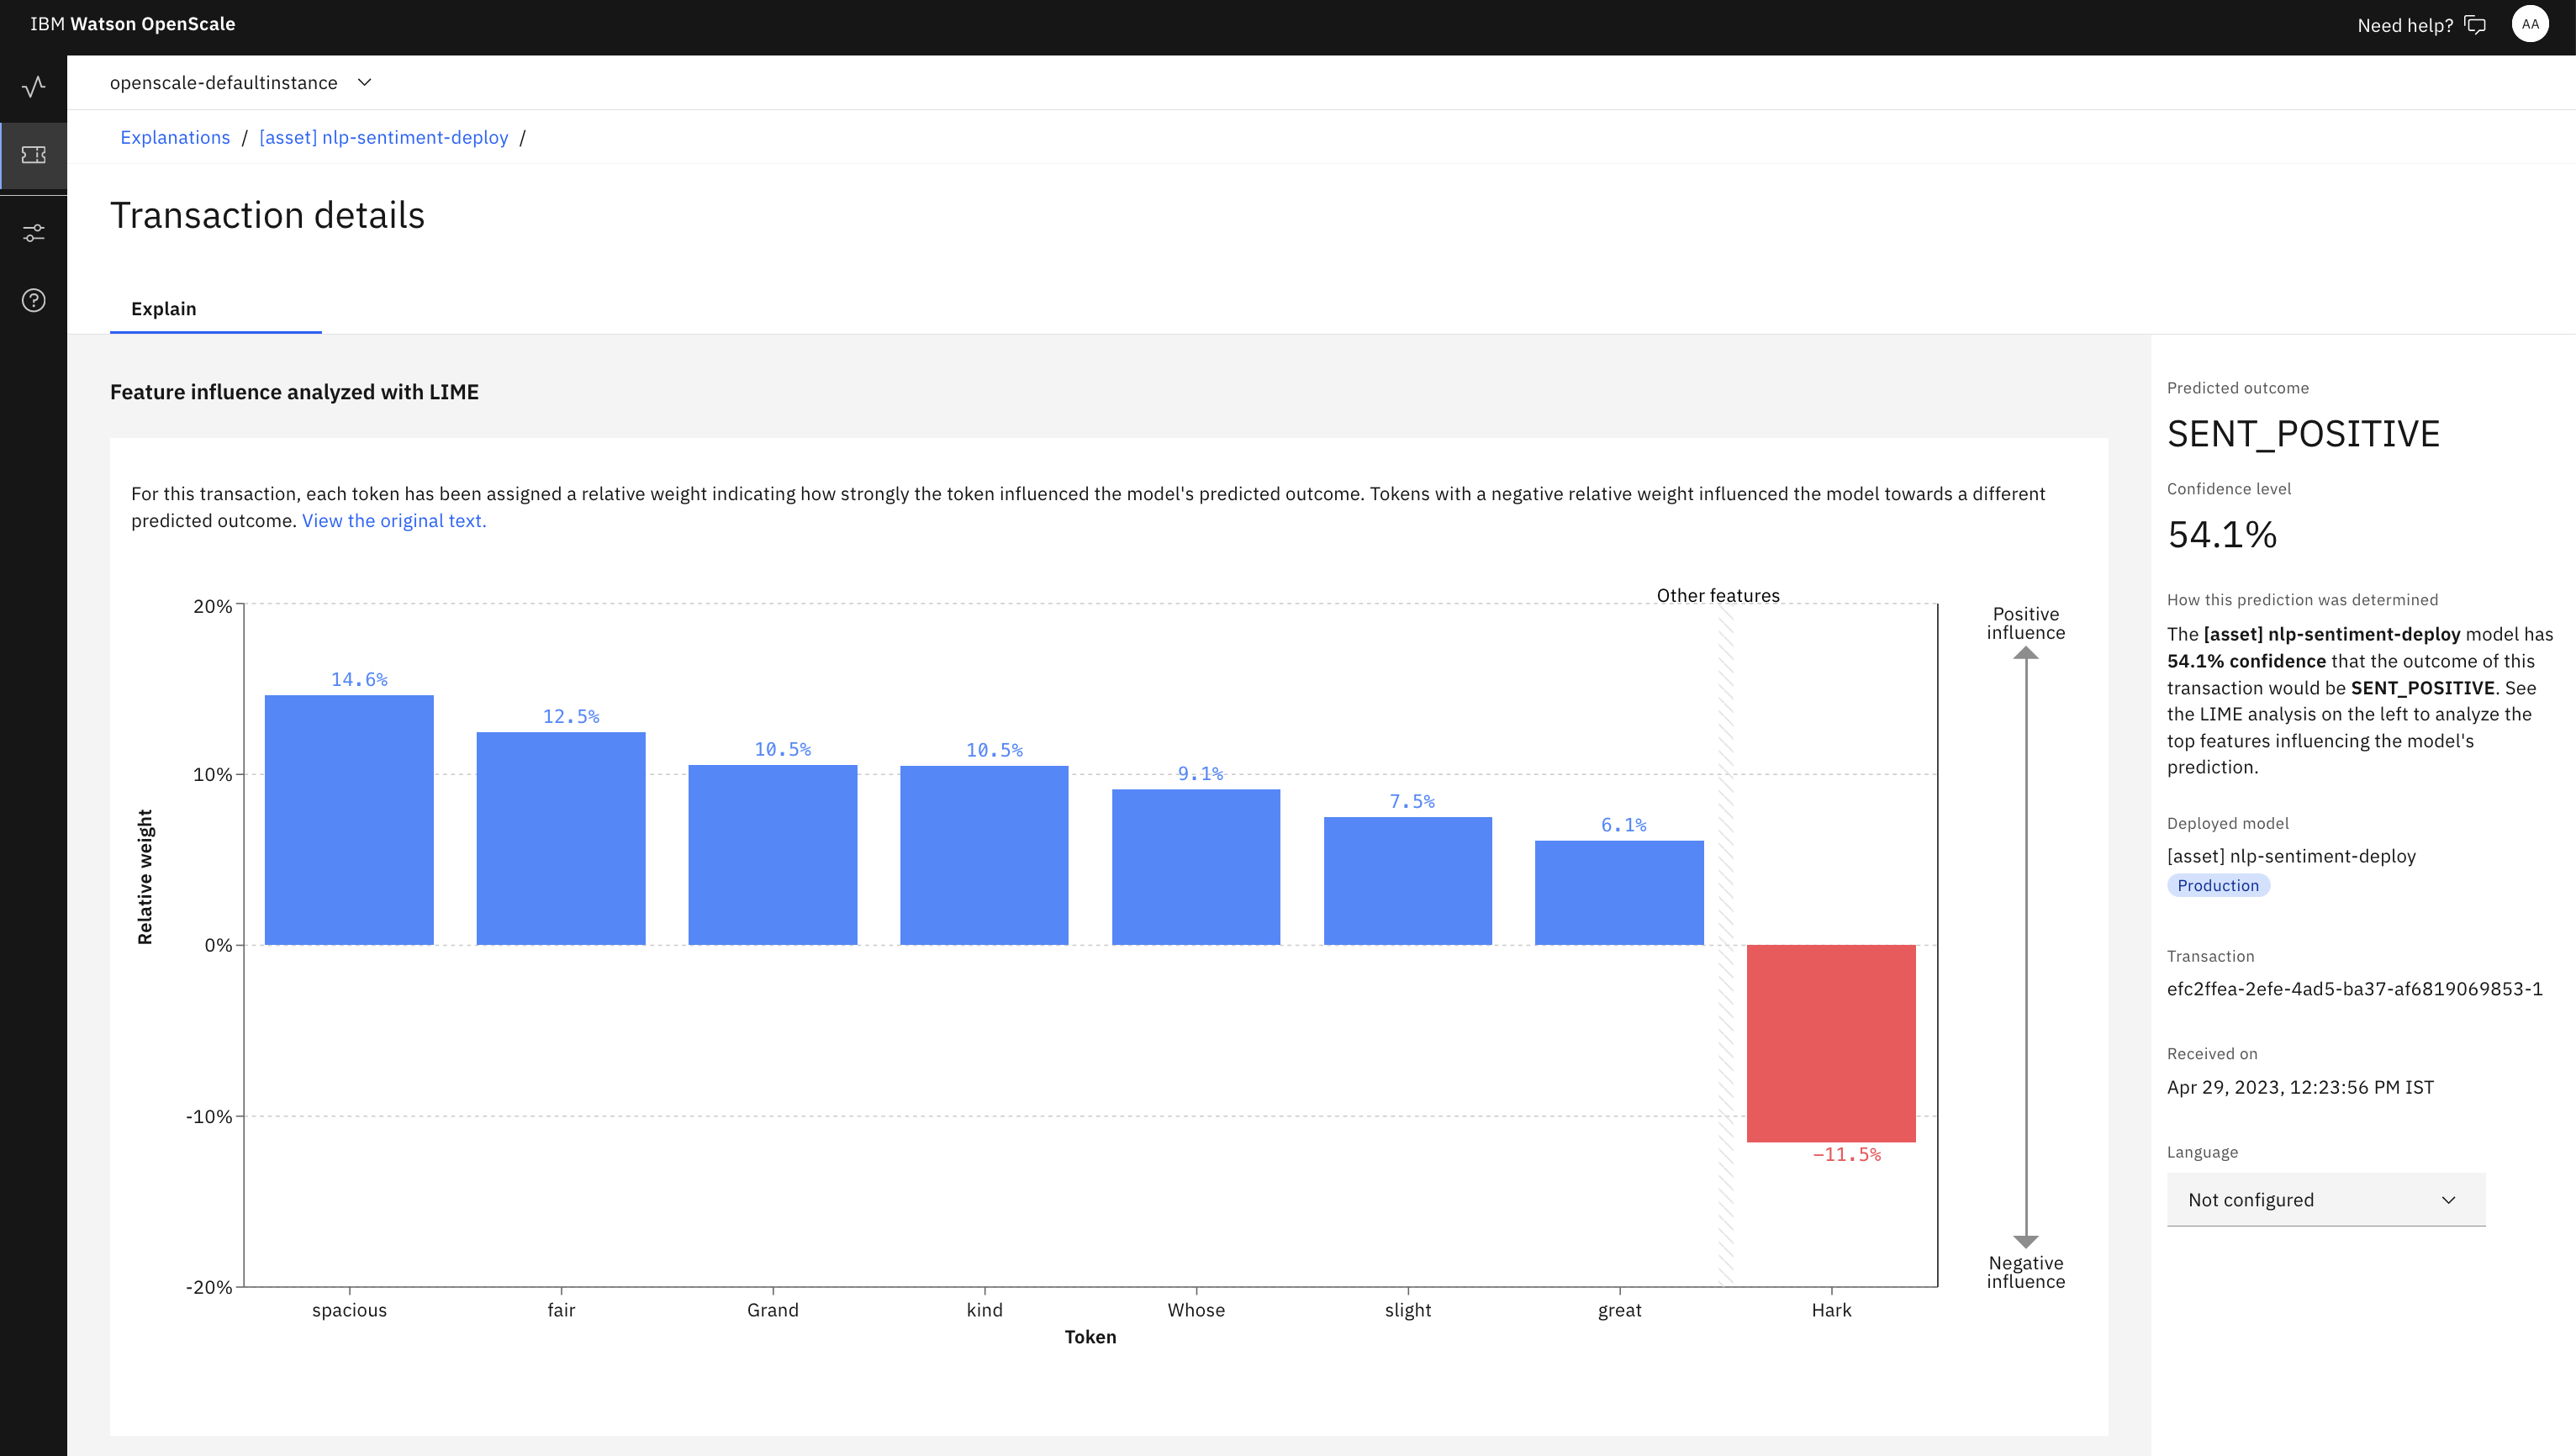

# Quality Metrics
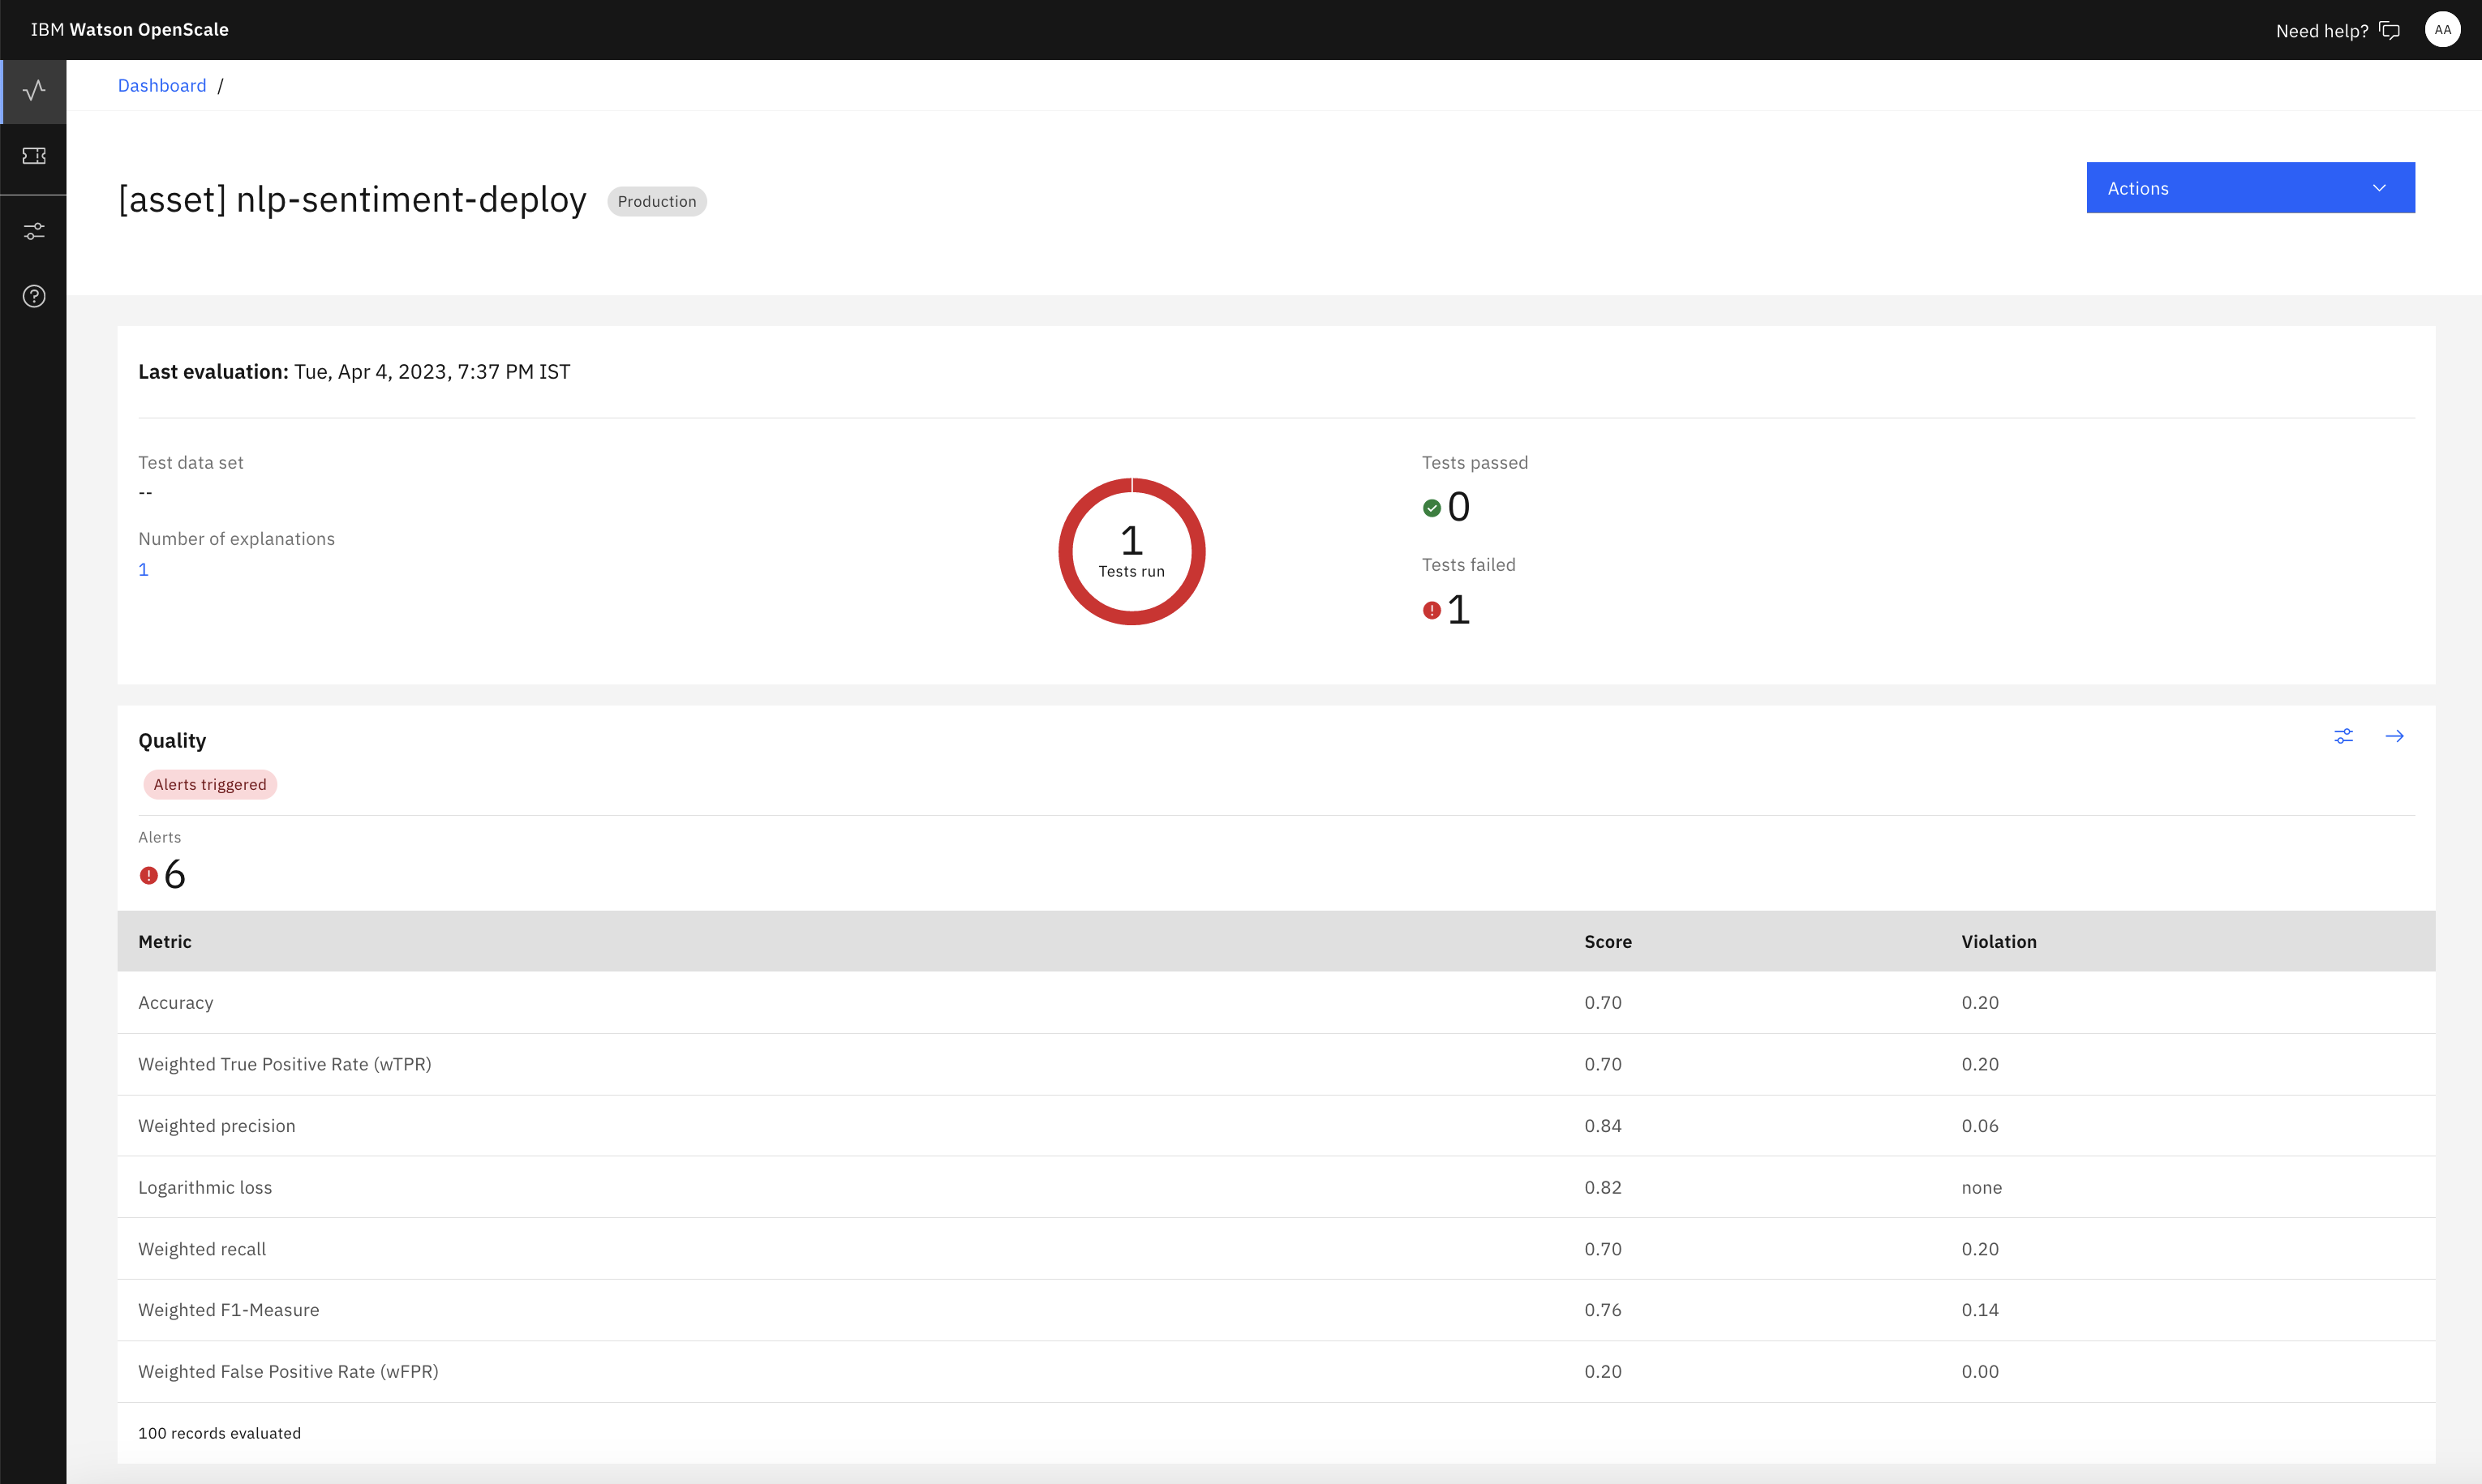

Author: Ravi Chamarthy (ravi.chamarthy@in.ibm.com)